In [1]:
# visualize_prediction.py
import torch
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
sys.path.append("src")

from neurosymbolic_model import SafeWithScallopLitModel
from ppe_dm_strict_prefilter import PPEDataModule

# --- CONFIG ---
CKPT_PATH = "checkpoints_v5/safe/last.ckpt"
DATA_ROOT = "data/ppe/css-data"
IMG_SIZE  = 224
BATCH_SIZE = 8
NUM_WORKERS = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
# --- helper: denormalize ImageNet-normalized tensors for display ---
def denormalize(img_t, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    img = img_t.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img.clamp(0, 1)

# 1) Load DataModule
dm = PPEDataModule(
    root_dir=DATA_ROOT,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_augment=False,      # no need for augments when visualizing
    person_margin=0.05,
    min_person_area_frac=0.0,
)
dm.setup("fit")
val_loader = dm.val_dataloader()

# 2) Load model from checkpoint
model = SafeWithScallopLitModel.load_from_checkpoint(CKPT_PATH, map_location=DEVICE)
model.eval().to(DEVICE)

[PPEDataModule] Split 'train': kept 2526 samples with a valid Person bbox.
[PPEDataModule] Split 'valid': kept 84 samples with a valid Person bbox.


SafeWithScallopLitModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

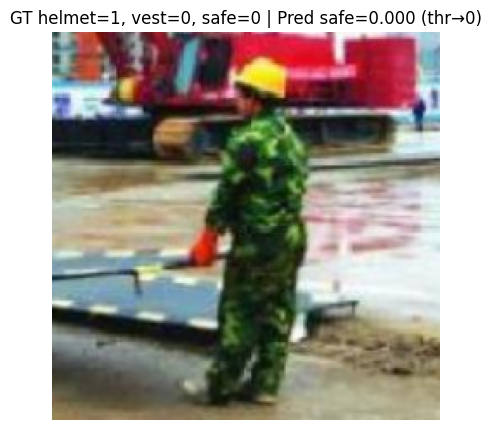

In [3]:
# 3) Grab one batch
images, ys = next(iter(val_loader))   # images: [B,3,H,W], ys: [B,10]
images = images.to(DEVICE)
ys = ys.to(DEVICE)

# Ground-truth (from your dataset schema)
# 0 = Hardhat, 7 = Safety Vest
gt_helmet = (ys[:, 0] > 0.5).float()
gt_vest   = (ys[:, 7] > 0.5).float()
gt_safe   = (gt_helmet * gt_vest)

# 4) Model prediction (only person_is_safe probability)
with torch.no_grad():
    p_safe = model(images)           # [B]
pred_safe = (p_safe >= 0.5).float()

# 5) Visualize the first sample in the batch
k = 0  # change index to see others
img_disp = denormalize(images[k].detach().cpu()).permute(1,2,0).numpy()

title = (
    f"GT helmet={int(gt_helmet[k].item())}, vest={int(gt_vest[k].item())}, "
    f"safe={int(gt_safe[k].item())} | "
    f"Pred safe={float(p_safe[k].item()):.3f} (thr→{int(pred_safe[k].item())})"
)

plt.figure(figsize=(4.4, 4.4))
plt.imshow(img_disp)
plt.axis('off')
plt.title(title)
plt.tight_layout()
plt.show()